In [101]:
import lightgbm as lgb
import pandas as pd
import sklearn
import numpy as np

In [102]:
df = pd.read_csv("./finalMergedData.csv")
# Assuming your DataFrame is called df
df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,height_x,weight_x,collegeName,Full Name,Team,Position,yearsPro,overall_rating,teamId,age
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,6-3,261,Iowa,Parker Hesse,Falcons,TE,2.0,52.0,14.0,27.0
1,2022091100,121,48723,Parker Hesse,(13:41) (Shotgun) M.Mariota pass short middle ...,1,3,4,ATL,NO,...,6-3,261,Iowa,Parker Hesse,Falcons,TE,2.0,52.0,14.0,27.0
2,2022091807,1217,48723,Parker Hesse,(5:30) M.Mariota pass short right to P.Hesse t...,2,4,1,ATL,LA,...,6-3,261,Iowa,Parker Hesse,Falcons,TE,2.0,52.0,14.0,27.0
3,2022100201,749,48723,Parker Hesse,(2:11) (Shotgun) M.Mariota pass deep left to P...,1,2,14,ATL,CLE,...,6-3,261,Iowa,Parker Hesse,Falcons,TE,2.0,52.0,14.0,27.0
4,2022103001,959,48723,Parker Hesse,(13:40) (Shotgun) M.Mariota pass short left to...,2,2,7,ATL,CAR,...,6-3,261,Iowa,Parker Hesse,Falcons,TE,2.0,52.0,14.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,2022101610,3088,48011,Tommy Sweeney,(2:05) J.Allen pass short right to T.Sweeney t...,3,2,6,BUF,KC,...,6-5,251,Boston College,Tommy Sweeney,Bills,TE,3.0,64.0,3.0,27.0
11344,2022100600,2612,48318,Devine Ozigbo,(8:51) D.Ozigbo up the middle to DEN 27 for 2 ...,3,1,10,DEN,IND,...,6-0,225,Nebraska,Devine Ozigbo,Saints,HB,3.0,63.0,27.0,25.0
11345,2022092600,1204,54553,Jalen Tolbert,(9:58) (Shotgun) C.Rush pass short right to J....,2,2,7,DAL,NYG,...,6-3,195,South Alabama,Jalen Tolbert,Cowboys,WR,0.0,71.0,11.0,23.0
11346,2022091803,2064,52620,Dezmon Patmon,(8:56) (Shotgun) M.Ryan pass short middle to D...,3,2,10,IND,JAX,...,6-4,220,Washington State,Dezmon Patmon,Colts,WR,2.0,64.0,10.0,24.0


In [103]:
df.columns
columns = ['gameId','ballCarrierId','ballCarrierDisplayName','playDescription','passResult','passLength','penaltyYards','prePenaltyPlayResult','playNullifiedByPenalty',
           'homeTeamWinProbabilityAdded','visitorTeamWinProbilityAdded','expectedPointsAdded','foulNFLId1','foulNFLId2','frameId','x','y','distanceToEndZone',
           'Full Name','teamId','foulName1','foulName2']
df = df.drop(columns=columns)

In [104]:
#this piece of data processing code is snipped from other people's kaggle notebook record. 
#https://www.kaggle.com/code/mansooralam559/classification-model-for-nfl-big-data-bowl-2024
def convert_height_to_meters(height):
    # Split the height into feet and inches
    feet, inches = map(int, height.split('-'))
    # Convert height to inches
    total_inches = feet * 12 + inches
    # Convert inches to cm (1 inch = 2.54 cm)
    height_cm = total_inches * 2.54
    # Convert cm to meters
    height_m = height_cm / 100
    return height_m
df['height_x'] = df['height_x'].apply(convert_height_to_meters)

def gameClockConverter(clock):
    minutes,second = map(int,clock.split(':'))
    totalTime = minutes*60 + second
    return totalTime
df['gameClock'] = df['gameClock'].apply(gameClockConverter)

#the open source kaggle notebook also reminds me of calculating the bmi of a player. This could be essential because it gives a more intuitive 
#and quantitative information about a player's physique.

In [105]:

df['yardlineSide'] = df['yardlineSide'].fillna('none')
df['offenseFormation']=df['offenseFormation'].fillna('none')
# deFendersIntheBoxMean = df['defendersInTheBox'].mean()
df['defendersInTheBox'] = df['defendersInTheBox'].fillna(df['defendersInTheBox'].mean())
df['passProbability'] = df['passProbability'].fillna(df['passProbability'].mean())

df.isna().sum()
# deFendersIntheBoxMean

playId                              0
quarter                             0
down                                0
yardsToGo                           0
possessionTeam                      0
defensiveTeam                       0
yardlineSide                        0
yardlineNumber                      0
gameClock                           0
preSnapHomeScore                    0
preSnapVisitorScore                 0
playResult                          0
absoluteYardlineNumber              0
offenseFormation                    0
defendersInTheBox                   0
passProbability                     0
preSnapHomeTeamWinProbability       0
preSnapVisitorTeamWinProbability    0
expectedPoints                      0
playDirection                       0
height_x                            0
weight_x                            0
collegeName                         0
Team                                0
Position                            0
yearsPro                            0
overall_rati

/var/folders/xv/l8hd10lx5gb4q4s4dpg_6xj40000gn/T/ipykernel_2022/2015275034.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


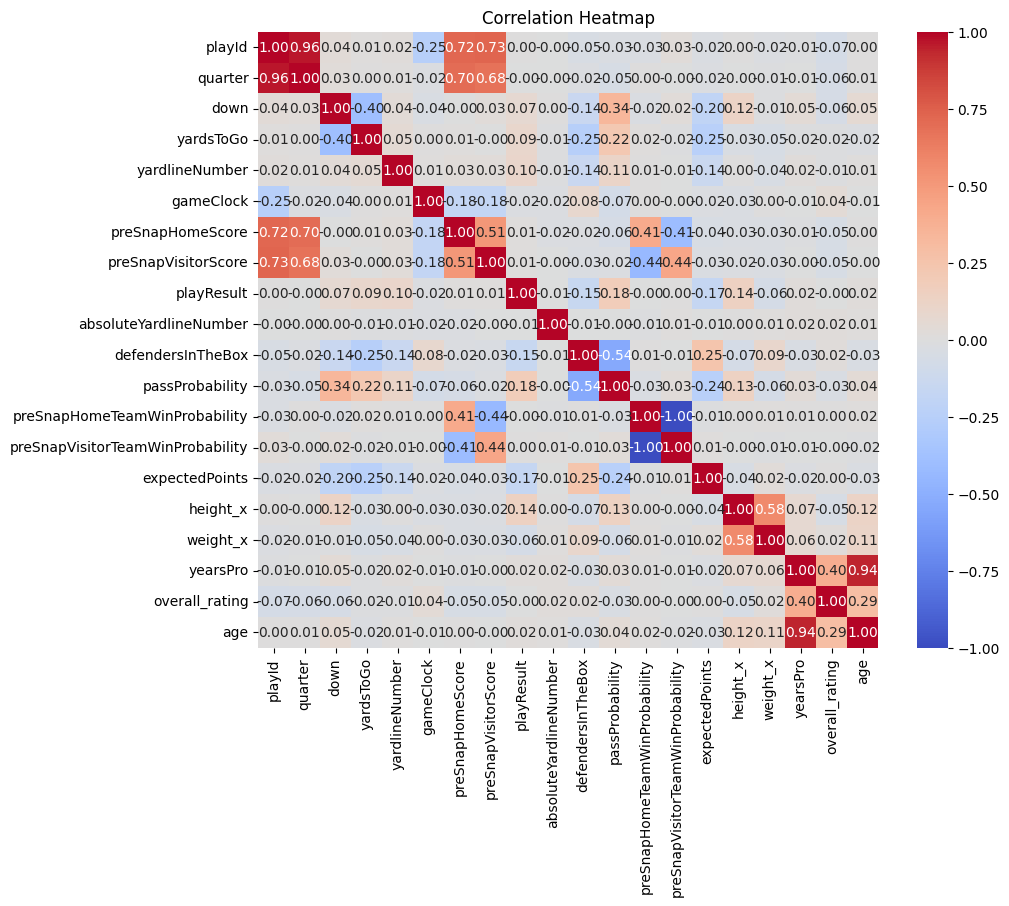

In [106]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt

#EDA for corr heapmap
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

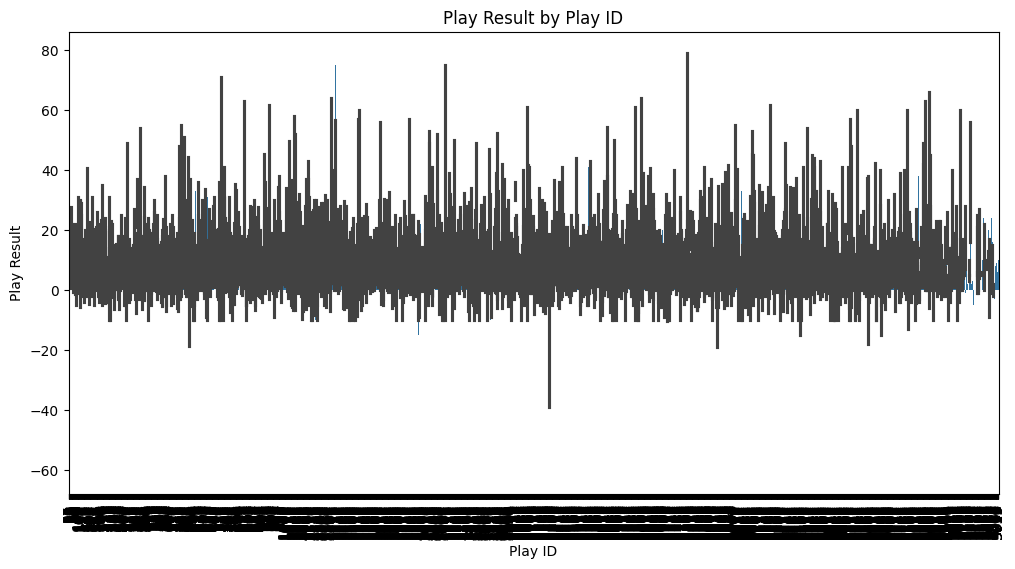

In [107]:
df['playId'] = df['playId'].astype('category')

# Plot barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='playId', y='playResult', data=df)
plt.title('Play Result by Play ID')
plt.xlabel('Play ID')
plt.ylabel('Play Result')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()



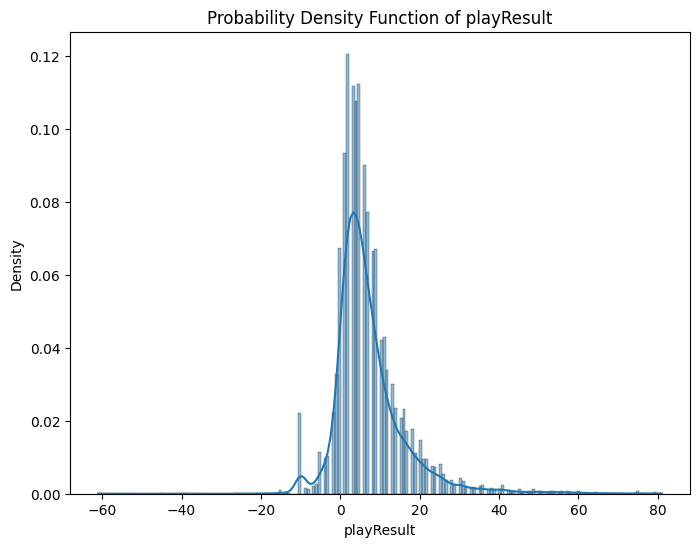

In [108]:
plt.figure(figsize=(8, 6))
sns.histplot(df['playResult'], kde=True, stat='density')
plt.title('Probability Density Function of playResult')
plt.xlabel('playResult')
plt.ylabel('Density')
plt.show()
#we can tell it is normally distributed

In [109]:
#scaling
from sklearn.preprocessing import StandardScaler

# Get list of numerical column names
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Remove playResult from numerical_cols
numerical_cols.remove('playResult')

# Separate numerical and categorical features
X_numerical = df[numerical_cols]  # Only include numerical columns
X_categorical = df.drop(columns=numerical_cols + ['playResult'])  # Exclude numerical and target columns

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize numerical features (excluding playResult)
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Convert the standardized numerical features back to a DataFrame
X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=X_numerical.columns)

# Concatenate the standardized numerical features with the categorical features and playResult column
df_standardized = pd.concat([X_numerical_scaled_df, X_categorical, df['playResult']], axis=1)

# Now df_standardized contains the entire dataset with numerical features standardized except for playResult
numerical_cols

['quarter',
 'down',
 'yardsToGo',
 'yardlineNumber',
 'gameClock',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'absoluteYardlineNumber',
 'defendersInTheBox',
 'passProbability',
 'preSnapHomeTeamWinProbability',
 'preSnapVisitorTeamWinProbability',
 'expectedPoints',
 'height_x',
 'weight_x',
 'yearsPro',
 'overall_rating',
 'age']

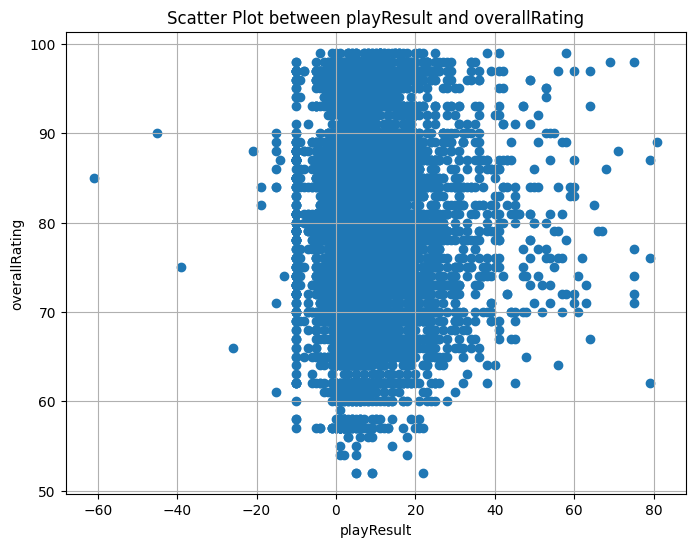

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(df['playResult'], df['overall_rating'])
plt.title('Scatter Plot between playResult and overallRating')
plt.xlabel('playResult')
plt.ylabel('overallRating')
plt.grid(True)
plt.show()

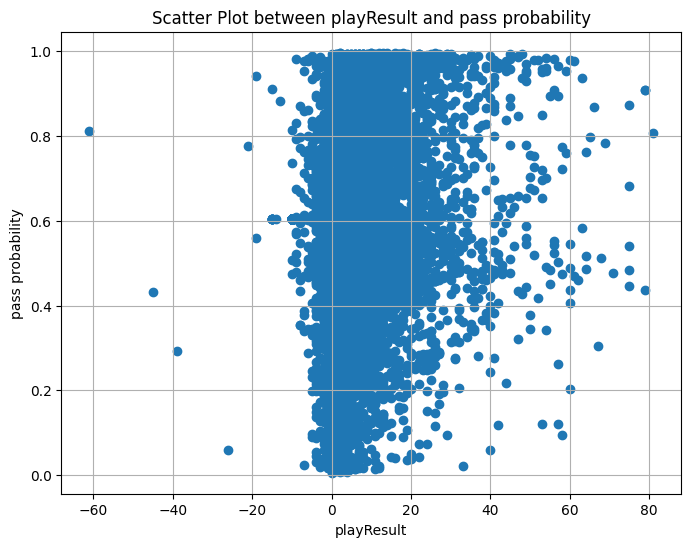

In [111]:
plt.figure(figsize=(8, 6))
plt.scatter(df['playResult'], df['passProbability'])
plt.title('Scatter Plot between playResult and pass probability')
plt.xlabel('playResult')
plt.ylabel('pass probability')
plt.grid(True)
plt.show()

In [112]:
df_standardized

,quarter,down,yardsToGo,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,defendersInTheBox,passProbability,...,playId,possessionTeam,defensiveTeam,yardlineSide,offenseFormation,playDirection,collegeName,Team,Position,playResult
0,1.274946,-0.918198,0.397173,0.915164,0.113727,1.025407,-0.315867,0.355879,0.570704,0.610491,...,3537,ATL,TB,ATL,SHOTGUN,left,Iowa,Falcons,TE,9
1,-1.361688,1.588349,-1.126446,0.995623,1.416317,-1.193672,-1.078588,-0.356596,-0.414457,0.323694,...,121,ATL,NO,ATL,SHOTGUN,right,Iowa,Falcons,TE,5
2,-0.482810,2.841622,-1.888255,-1.337696,-0.416266,0.285714,-1.078588,1.529368,1.555866,-1.067448,...,1217,ATL,LA,LA,SINGLEBACK,right,Iowa,Falcons,TE,5
3,-1.361688,0.335075,1.412919,0.432408,-1.159003,-0.876660,-1.078588,0.607341,-0.414457,0.885612,...,749,ATL,CLE,CLE,EMPTY,right,Iowa,Falcons,TE,22
4,-0.482810,0.335075,-0.364636,1.558838,1.412585,-1.193672,-0.751708,-0.063224,0.570704,0.386121,...,959,ATL,CAR,ATL,SHOTGUN,right,Iowa,Falcons,TE,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,0.396068,0.335075,-0.618573,-0.050347,-1.181397,0.602726,0.773734,-0.901430,-0.414457,0.236960,...,3088,BUF,KC,BUF,SINGLEBACK,right,Boston College,Bills,TE,7
11344,0.396068,-0.918198,0.397173,-0.372184,0.333936,-0.559649,-0.424827,1.026444,0.570704,-0.475766,...,2612,DEN,IND,DEN,SINGLEBACK,left,Nebraska,Saints,HB,2
11345,-0.482810,0.335075,-0.364636,-1.257237,0.584003,-0.876660,-0.751708,1.487457,-1.399619,0.753652,...,1204,DAL,NYG,NYG,EMPTY,right,South Alabama,Cowboys,WR,4
11346,0.396068,0.335075,0.397173,0.351949,0.352598,0.602726,-1.078588,-0.691878,-0.414457,0.861224,...,2064,IND,JAX,IND,SHOTGUN,right,Washington State,Colts,WR,7


In [113]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_df = df_standardized.select_dtypes(include=['number'])

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
vif_data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,quarter,2.867394
1,down,1.692481
2,yardsToGo,1.618181
3,yardlineNumber,1.039211
4,gameClock,1.129936
5,preSnapHomeScore,4.972093
6,preSnapVisitorScore,4.815986
7,absoluteYardlineNumber,1.002436
8,defendersInTheBox,1.493065
9,passProbability,1.759839


In [114]:
df_standardized  = df_standardized.drop(columns=['preSnapVisitorTeamWinProbability'])

In [115]:
from sklearn.model_selection import train_test_split
X = df_standardized.drop(columns=['playResult'])  # Features
y = df_standardized['playResult']  # Target

# First split: Split the data into training (70%) and temporary (30%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split the temporary data into validation (50%) and final training (50%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)
print(X_train['playId'].nunique())# this is a lot of different plays
print(X_train.columns)

Training set shape: (6808, 26)
Validation set shape: (2270, 26)
Testing set shape: (2270, 26)
3310
Index(['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'expectedPoints', 'height_x', 'weight_x', 'yearsPro', 'overall_rating',
       'age', 'playId', 'possessionTeam', 'defensiveTeam', 'yardlineSide',
       'offenseFormation', 'playDirection', 'collegeName', 'Team', 'Position'],
      dtype='object')
